# HOMEWORK 4

## Read the data

We will read dataset that is about the stores. The data contains following information.

    1.UsesID: Id of a user.
    2.Gender: Gender of the customer.
    3.Age: Age of customer is years.
    4.EstimatedSalary: Yearly estimated salary of the customer.
    5.Purchased: Binary value with value 1 if the customer purchased the item, 0 otherwise.

In [103]:
options(warn=-1)
library(ggplot2)
storeData <- read.csv('social.csv')

### Inspect the data read

In [104]:
head(storeData)

User.ID,Gender,Age,EstimatedSalary,Purchased
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0
15728773,Male,27,58000,0


#### Spends are already reduced in given data.

In [105]:
cat("Size of Store data",dim.data.frame(storeData))

Size of Store data 400 5

## Aim is to train a support vector machine(SVM) that will predict whether a customer will purchase or not.

##### Spliting the data as training and testing data

In [106]:
# sampling data to generate 75% training data and 25% test data
sdata <- sample(nrow(storeData), nrow(storeData)*0.75)
sampledata <- sort(sample(nrow(storeData), nrow(storeData)*0.75))
trainingData<-storeData[sampledata,]
testingData<-storeData[-sampledata,]



In [107]:
cat("Trainig Data :: ","Size :: ", dim.data.frame(trainingData))
head(trainingData)
cat("Testing Data :: ","Size :: ", dim.data.frame(testingData))
head(testingData)

Trainig Data ::  Size ::  300 5

,User.ID,Gender,Age,EstimatedSalary,Purchased
2,15810944,Male,35,20000,0
3,15668575,Female,26,43000,0
5,15804002,Male,19,76000,0
9,15600575,Male,25,33000,0
11,15570769,Female,26,80000,0
13,15746139,Male,20,86000,0


Testing Data ::  Size ::  100 5

,User.ID,Gender,Age,EstimatedSalary,Purchased
1,15624510,Male,19,19000,0
4,15603246,Female,27,57000,0
6,15728773,Male,27,58000,0
7,15598044,Female,27,84000,0
8,15694829,Female,32,150000,1
10,15727311,Female,35,65000,0


##### Preprocessing data for modelling 

In [108]:
# converting dataframe into matrix with required data. We are using only Age and EstimatedSalary
ytrain <- as.matrix(trainingData$Purchased)
# creating yn for computation assigning +1 to 1 and -1 to 0
ytrain <- matrix(apply(ytrain, 1, function (var) {if (var == 1) return (1) else return (-1)}))
colnames(ytrain) <- c("Purchased")
ones <- matrix(rep(1,nrow(ytrain)), nrow = nrow(ytrain), ncol = 1)
# Adding ones in first column of data for bias parameter
xtrain <- cbind(ones,trainingData$Age,trainingData$EstimatedSalary)
colnames(xtrain) <- c("ones","Age","EstimatedSalary")
cat("Trainig Data:: Input and Output" )
head(xtrain)
head(ytrain)
ytest <- as.matrix(testingData$Purchased)
# creating yn for computation assigning +1 to 1 and -1 to 0
ytest <- matrix(apply(ytest, 1, function (var) {if (var == 1) return (1) else return (-1)}))
colnames(ytest) <- c("Purchased")
ones <- matrix(rep(1,nrow(ytest)), nrow = nrow(ytest), ncol = 1)
# Adding ones in first column of data for bias parameter
xtest <- cbind(ones,testingData$Age,testingData$EstimatedSalary)
colnames(xtest) <- c("ones","Age","EstimatedSalary")
cat("Testing Data:: Input and Output" )
head(xtest)
head(ytest)

Trainig Data:: Input and Output

ones,Age,EstimatedSalary
1,35,20000
1,26,43000
1,19,76000
1,25,33000
1,26,80000
1,20,86000


Purchased
-1
-1
-1
-1
-1
-1


Testing Data:: Input and Output

ones,Age,EstimatedSalary
1,19,19000
1,27,57000
1,27,58000
1,27,84000
1,32,150000
1,35,65000


Purchased
-1
-1
-1
-1
1
-1


In [109]:
#Scaling predictor variables for training data
xtrain[,2] <- (xtrain[,2] - mean(xtrain[,2]))/sd(xtrain[,2])
xtrain[,3] <- (xtrain[,3]- mean(xtrain[,3]))/sd(xtrain[,3])
cat("Training Input data after normalization")
head(xtrain)

#Scaling predictor variables for testing data
xtest[,2] <- (xtest[,2] - mean(xtest[,2]))/sd(xtest[,2])
xtest[,3] <- (xtest[,3]- mean(xtest[,3]))/sd(xtest[,3])
cat("Testing Input data after normalization")
head(xtest)

Training Input data after normalization

ones,Age,EstimatedSalary
1,-0.3249205,-1.4065133
1,-1.1824821,-0.7552187
1,-1.8494744,0.1792476
1,-1.2777667,-1.0383903
1,-1.1824821,0.2925163
1,-1.7541898,0.4624192


Testing Input data after normalization

ones,Age,EstimatedSalary
1,-1.61236437,-1.6809336
1,-0.82536529,-0.4274902
1,-0.82536529,-0.3945048
1,-0.82536529,0.4631144
1,-0.33349086,2.6401477
1,-0.03836621,-0.1636074


#### Defining functions for subgradient  and loss function  

In [110]:
g <- function(t){
    if (t < 1)
        return (-1)
    else
        return (0)
}

# define tn = yn(<w,xn>)
    # yn is the output for nth index
    # xn is the input for nth index
    # x = [b w1 w2]'

tn <- function(yn, x, xn){
    t <- yn * ((xn%*%x))
    return (t)
}


#compute loss as terminating condition
loss <-function(x,C){
    N <- dim(xtrain)[1]
    distances <- 1 - ytrain * (xtrain%*%x)
    distances[distances < 0] <- 0  # equivalent to max(0, distance)
    hinge_loss <- C * (sum(distances) / N)
    # calculate cost
    cost <- 1 / 2 * t(x)%*%x + hinge_loss
    return (cost)
}


gradient <- function(x, C){
    deltaF <- matrix(rep(0,3), nrow = 3, ncol = 1)
    sum<- matrix(rep(0,3), nrow = 3, ncol = 1)
    for (n in seq(length(ytrain)))
        {
        t = tn(ytrain[n],x,xtrain[n,])
        gn = g(t)                                                                     
        diff <- x + (C * gn * ytrain[n] * xtrain[n,])
        sum <- sum + diff
    }
    deltaF <- sum/length(ytrain)
    return (deltaF)
}

#### Defining functions execute gradient descent for SVM, generate prediction, compute accuracy and genearte confusion matrix

In [111]:
# Run gradient descent for SVM
gradientDescent <- function(x, C, alpha,thrs,maxi){
    converged<-FALSE
    i<-1
    x1<-x
    prev_lossvalue <- 0
     while((!converged  && i <= maxi))
            {
                deltafx <- gradient(x1,C)
                if(is.infinite(deltafx) || is.nan(norm(deltafx,type = "2"))){
                    break
                }
                x1 <- x1 - (alpha*deltafx)
                lossvalue <- loss(x1,C)
                # terminating condition based on loss function
                converged <-abs(prev_lossvalue - lossvalue) < thrs * prev_lossvalue
                prev_lossvalue <- lossvalue
                i <- i+1
            }

    return (list("x1"= x1,"iteration" = i-1,"converged" = converged, "lossValue" = prev_lossvalue))
}

# generate prediction
predict <- function(data,featurecoffiecients)
    {
    result <- data%*%featurecoffiecients
    result[result < 0] <- -1
    result[result > 0] <- 1 
    return(result)
}

# compute accuracy
accuracy <- function(predicted, actual)
    {
    return((sum(predicted==actual)/dim(predicted)[1])*100)
}

# generate confusion matrix
generateconfusionmatrix <- function(predicted, actual)
{
    consfusionMatrix <- matrix(rep(0,4), nrow = 2, ncol = 2)
    colnames(consfusionMatrix) <- c("actual(1)","actual(-1)")
    rownames(consfusionMatrix) <- c("pred(1)","pred(-1)")
    consfusionMatrix

    for (i in seq(length(actual)))
    {
        if (actual[i] ==1 & predicted[i] ==1)
            {
            consfusionMatrix[1,1] = consfusionMatrix[1,1] + 1
        }

        else if (actual[i] ==1 & predicted[i] ==-1)
        {
            consfusionMatrix[2,1] = consfusionMatrix[2,1] + 1
        }

        else if (actual[i] ==-1 & predicted[i] ==1)
        {
            consfusionMatrix[1,2] = consfusionMatrix[1,2] + 1
        }

        else if (actual[i] ==-1 & predicted[i] ==-1)
        {
            consfusionMatrix[2,2] = consfusionMatrix[2,2] + 1
        }

    }
    
    return (consfusionMatrix)
}

#### Running SVM for tradeoff factor = 50

In [112]:
#setting tradoff parameter to 50
C <- 50
# x = [w1 w2 b]'
x <- matrix(rep(0,3), nrow = 3, ncol = 1)
thres <- 10**(-2)
maxiter <- 1000
alpha <- 0.01
answer <- gradientDescent(x, C,alpha,thres,maxiter)
wstar <- answer$x
cat("Coffiecients")
wstar
#prediction
prediction <- predict(xtest,wstar)
#accuracy
accuracyper1 <- accuracy(prediction,ytest)
cat("Accuarcy is :: ", accuracyper1,"%","\n")
#confusion matrix
cat("Confusion Matrix")
cmatrix1 <- generateconfusionmatrix(prediction,ytest)
cmatrix1

Coffiecients

-0.5130687
0.9951247
0.4937978


Accuarcy is ::  87 % 
Confusion Matrix

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


In [113]:
# generating points to plot classification line
Age = seq(-2,2,0.1)
# wstar[1] represents b, wstar[2] and wstar[3] represents the paraneter for Age and salary
EstimatesSalary = -(wstar[2]*Age+wstar[1])/wstar[3]
data1 <- as.data.frame(cbind(Age,EstimatesSalary))

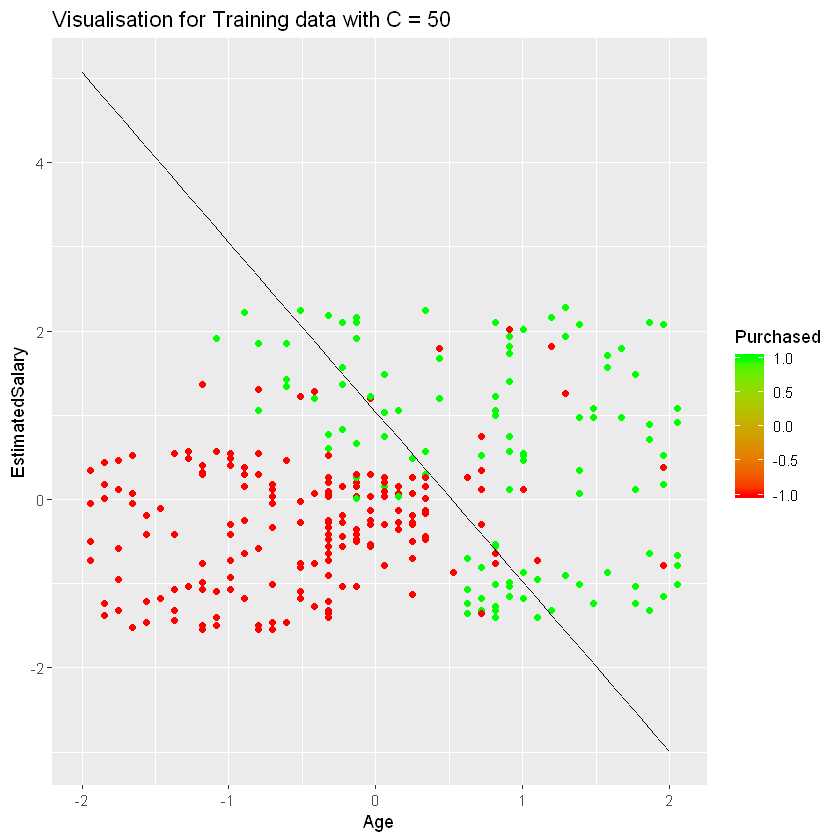

In [114]:
data <- as.data.frame(cbind(xtrain,ytrain))
sp <- ggplot() + geom_point(data, mapping = aes(x = Age, y = EstimatedSalary,color = Purchased)) +
scale_colour_gradient(low = "red", high = "green")
sp + geom_line(data1, mapping = aes(x = Age, y = EstimatesSalary)) +
ggtitle("Visualisation for Training data with C = 50")

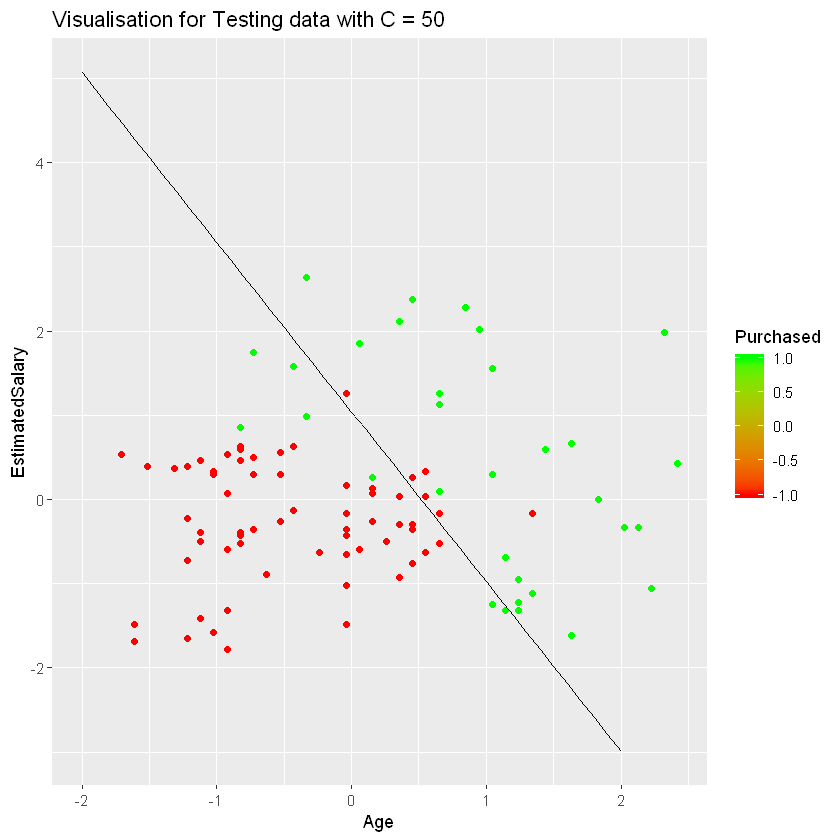

In [115]:
data <- as.data.frame(cbind(xtest,ytest))
# data
library(ggplot2)
sp <- ggplot() + geom_point(data, mapping = aes(x = Age, y = EstimatedSalary, color = Purchased))+ 
scale_colour_gradient(low = "red", high = "green")
sp + geom_line(data1, mapping = aes(x = Age, y = EstimatesSalary))+ 
ggtitle("Visualisation for Testing data with C = 50")

#### Running SVM for tradeoff factor = 1, 75 and 100

In [116]:
#setting tradoff parameter to 1
C <- 1
# x = [w1 w2 b]'
x <- matrix(rep(0,3), nrow = 3, ncol = 1)
thres <- 10**(-2)
maxiter <- 1000
alpha <- 0.01
answer <- gradientDescent(x, C,alpha,thres,maxiter)
wstar <- answer$x
#prediction
prediction <- predict(xtest,wstar)
#accuracy
accuracyper2 <- accuracy(prediction,ytest)
cat("Accuarcy is :: ", accuracyper2,"%","\n")
#confusion matrix
cat("Confusion Matrix")
cmatrix2 <- generateconfusionmatrix(prediction,ytest)
cmatrix2

Accuarcy is ::  88 % 
Confusion Matrix

,actual(1),actual(-1)
pred(1),27,6
pred(-1),6,61


In [117]:
#setting tradoff parameter to 75
C <- 75
# x = [w1 w2 b]'
x <- matrix(rep(0,3), nrow = 3, ncol = 1)
thres <- 10**(-2)
maxiter <- 1000
alpha <- 0.01
answer <- gradientDescent(x, C,alpha,thres,maxiter)
wstar <- answer$x
#prediction
prediction <- predict(xtest,wstar)
#accuracy
accuracyper3 <- accuracy(prediction,ytest)
cat("Accuarcy is :: ", accuracyper3,"%","\n")
#confusion matrix
cat("Confusion Matrix")
cmatrix3 <- generateconfusionmatrix(prediction,ytest)
cmatrix3

Accuarcy is ::  87 % 
Confusion Matrix

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


In [118]:
#setting tradoff parameter to 75
C <- 100
# x = [b w1 w2]'
x <- matrix(rep(0,3), nrow = 3, ncol = 1)
thres <- 10**(-2)
maxiter <- 1000
alpha <- 0.01
answer <- gradientDescent(x, C,alpha,thres,maxiter)
wstar <- answer$x
#prediction
prediction <- predict(xtest,wstar)
#accuracy
accuracyper4 <- accuracy(prediction,ytest)
cat("Accuarcy is :: ", accuracyper4,"%","\n")
#confusion matrix
cat("Confusion Matrix")
cmatrix4 <- generateconfusionmatrix(prediction,ytest)
cmatrix4

Accuarcy is ::  87 % 
Confusion Matrix

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


In [119]:
cat("Confusion Matrix and accuracy (%)  for C = 1")
cmatrix2
accuracyper2
cat("Confusion Matrix and accuracy (%) for C = 50")
cmatrix1
accuracyper1
cat("Confusion Matrixa and accuracy (%) for C = 75")
cmatrix3
accuracyper3
cat("Confusion Matrix and accuracy (%) for C = 100")
cmatrix4
accuracyper4

Confusion Matrix and accuracy (%)  for C = 1

,actual(1),actual(-1)
pred(1),27,6
pred(-1),6,61


[1] 88

Confusion Matrix and accuracy (%) for C = 50

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


[1] 87

Confusion Matrixa and accuracy (%) for C = 75

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


[1] 87

Confusion Matrix and accuracy (%) for C = 100

,actual(1),actual(-1)
pred(1),26,6
pred(-1),7,61


[1] 87

#### What happens to the confusion matrix if you use C = 100? What happens to the confusion matrix if you use C = 1? Comment on what the effect of C is on the entries of the confusion matrix. What choice of C gives you the best classification accuracy results on the test data?

I ran SVM for trade-off factors 1, 50, 75 and 100. Accuracy is best (88%) for trade-off fator C = 1 while accuracy for trade-off 50, 75 and 100 is same 87%. Also as trade-off is increased from 1, there is  decrease in "TRUE POSITIVE" cases from 27 to 26 and increase in "TRUE NEGATIVE" cases from 6 to 7.

Given the observation, C = 1 gives the best accuracy.

Github link for the code 

https://github.com/jainsanyam786/OptimizationForMachineLearning.git